In [3]:
! pip install -q bertopic datasets gensim

In [4]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from bertopic import BERTopic
from umap import UMAP
from gensim.models.poincare import PoincareModel
from nltk.corpus import wordnet as wn
import nltk
import csv
import os
import itertools
from tqdm import tqdm
import random
from gensim.models.poincare import LinkPredictionEvaluation, ReconstructionEvaluation
import pandas as pd
# from utils.bench_mark import generate_bench_mark

In [25]:
! mkdir -p outputs data

In [11]:
OUTPUT_DIR = "outputs"

In [6]:
dataset = load_dataset("tweet_eval", "offensive")

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/11916 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/860 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1324 [00:00<?, ? examples/s]

In [7]:
# TODO Do a prettier print of the dataset dictionary
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 11916
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 860
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1324
    })
})

In [8]:
# do a pretty of sample train dataset
train_ds = dataset["train"]
train_ds[0]

{'text': '@user Bono... who cares. Soon people will understand that they gain nothing from following a phony celebrity. Become a Leader of your people instead or help and support your fellow countrymen.',
 'label': 0}

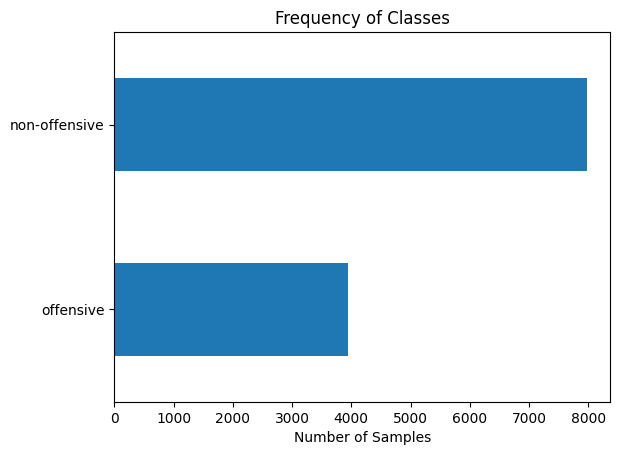

In [12]:
dataset.set_format(type="pandas")
df = dataset["train"][:]

def label_int2str(row):
    return dataset["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

df["label_name"].value_counts(ascending=True).plot.barh()
plt.xlabel("Number of Samples")
plt.title("Frequency of Classes")
plt.savefig(os.path.join(OUTPUT_DIR, "class_frequency.png"))
plt.show()

In [13]:

umap_model = UMAP(random_state=42)

topic_model = BERTopic(umap_model=umap_model)

In [14]:
train_docs = dataset["train"]['text']
train_classes = dataset["train"]['label']
test_docs = dataset["test"]['text']
test_classes = dataset["test"]['label']
valid_docs = dataset["validation"]['text']
valid_classes = dataset["validation"]['label']

In [15]:
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True, embedding_model="all-MiniLM-L6-v2")
topics, probs = topic_model.fit_transform(train_docs)

Batches:   0%|          | 0/373 [00:00<?, ?it/s]

2023-11-02 20:00:47,334 - BERTopic - Transformed documents to Embeddings
2023-11-02 20:01:30,470 - BERTopic - Reduced dimensionality
2023-11-02 20:01:40,922 - BERTopic - Clustered reduced embeddings


In [16]:
topic_model.get_topic_info()


,Topic,Count,Name,Representation,Representative_Docs
0,-1,4439,-1_is_he_she_you,"[is, he, she, you, to, and, the, are, of, user]",[@user @user I know how you feel Stormy Daniel...
1,0,1100,0_antifa_user_they_the,"[antifa, user, they, the, of, and, to, violenc...",[@user @user @user @user Antifa are the fascis...
2,1,1014,1_gun_control_guns_laws,"[gun, control, guns, laws, the, about, in, to,...","[@user Or we could have gun control, @user @us..."
3,2,364,2_liberals_liberal_they_user,"[liberals, liberal, they, user, all, are, the,...","[@user That they're liberals, @user @user @use..."
4,3,336,3_right_user_wrong_you,"[right, user, wrong, you, are, correct, he, sh...",[@user @user @user @user @user @user @user @us...
...,...,...,...,...,...
109,108,11,108_team_birds_play_he,"[team, birds, play, he, played, season, coach,...",[@user Would you resign with the boys? Just cu...
110,109,11,109_flake_snow_buh_melting,"[flake, snow, buh, melting, snowflake, flakes,...","[@user @user Flake is a real flake, @user He’s..."
111,110,11,110_scared_scary_frightening_spiders,"[scared, scary, frightening, spiders, arachnop...","[@user @user you are running scared!🤡, @user @..."
112,111,10,111_citizenship_home_lawyer_country,"[citizenship, home, lawyer, country, americans...",[@user Easy for the elites to escape the hell ...


In [17]:
topic_model.get_topic(0)

[('antifa', 0.04236447036460724),
 ('user', 0.011248906415503222),
 ('they', 0.008285716328914141),
 ('the', 0.007917718514330057),
 ('of', 0.007598449967748323),
 ('and', 0.007326341594014143),
 ('to', 0.006880562257177301),
 ('violence', 0.006651281644099103),
 ('left', 0.006645265314948763),
 ('like', 0.006448286648349674)]

In [18]:
len(topic_model.get_topics().values())

114

In [19]:
embeddings = []
for topic in topic_model.get_topics().values():
    topic_embeddings = []
    for i in range(len(topic) - 1):
        for j in range(i + 1, len(topic)):
            topic_embeddings.append([topic[j][0], topic[i][0]])
    embeddings.append(topic_embeddings)
print(embeddings[0])

[['he', 'is'], ['she', 'is'], ['you', 'is'], ['to', 'is'], ['and', 'is'], ['the', 'is'], ['are', 'is'], ['of', 'is'], ['user', 'is'], ['she', 'he'], ['you', 'he'], ['to', 'he'], ['and', 'he'], ['the', 'he'], ['are', 'he'], ['of', 'he'], ['user', 'he'], ['you', 'she'], ['to', 'she'], ['and', 'she'], ['the', 'she'], ['are', 'she'], ['of', 'she'], ['user', 'she'], ['to', 'you'], ['and', 'you'], ['the', 'you'], ['are', 'you'], ['of', 'you'], ['user', 'you'], ['and', 'to'], ['the', 'to'], ['are', 'to'], ['of', 'to'], ['user', 'to'], ['the', 'and'], ['are', 'and'], ['of', 'and'], ['user', 'and'], ['are', 'the'], ['of', 'the'], ['user', 'the'], ['of', 'are'], ['user', 'are'], ['user', 'of']]


In [20]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [21]:
flat_list = [item for sublist in embeddings for embedding in sublist for item in embedding]

# Get unique words
vocab = list(set(flat_list))
print(f'Voabulary size: {len(vocab)}')
print(f'Sample of vocabulary: {vocab[:5]}')

Voabulary size: 884
Sample of vocabulary: ['user', 'huntsman', '18', 'blocked', 'boycottnike']


In [22]:
relations = []
def get_hypernym_relations(word, relations):
    """Get hypernym relations for a word."""
    for synset in wn.synsets(word):
        for hypernym in synset.hypernyms():
            hyp = [synset.lemmas()[0].name(), hypernym.lemmas()[0].name()]
            if len(hyp) != 0:
              relations.append(hyp)
    return relations

for v in vocab:
  get_hypernym_relations(f'{v}', relations)
print(f'Number of relations: {len(relations)}')

print(relations[:5])

Number of relations: 3069
[['user', 'person'], ['exploiter', 'selfish_person'], ['drug_user', 'person'], ['hunter', 'skilled_worker'], ['eighteen', 'large_integer']]


In [23]:

DATA_DIRECTORY = 'data'
test_size_ratio = 0.2
train_relation = relations[:int(len(relations) * (1 - test_size_ratio))]
print(f'Train relation size: {len(train_relation)}')
test_relation = relations[int(len(relations) * (1-test_size_ratio)):]
print(f'Test relation size: {len(test_relation)}')
train_relation_file_path = os.path.join(DATA_DIRECTORY, 'train_relation.tsv')
test_relation_file_path = os.path.join(DATA_DIRECTORY, 'test_relation.tsv')

Train relation size: 2455
Test relation size: 614


In [28]:
# Save train and test relations as tsv files
with open(train_relation_file_path, 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerows(train_relation)

with open(test_relation_file_path, 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerows(test_relation)
with open('relations.tsv', 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerows(relations)